## Property Features Analysis

The report below explains how different features impact the cost of a property in Brazil looking at the property area, condominium fee, nuumber of bedrooms and the number of bathrooms. This will help us to understand more about our data, the accuracy and help us to clean our data to improve future pricing estimatations.

In [5]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.stats as stats
from sklearn.datasets import load_iris
import plotly.express as px
import seaborn as sns
import geopandas as gpd

pd.set_option("display.max_columns",None)

# styling for charts
sns.set(style='whitegrid')
facecolor = '#eaeaf2'
font_color = '#525252'
csfont = {'fontname': 'Segoe UI'}
hfont = {'fontname': 'Arial'}

# Read file

In [6]:
salvador=gpd.read_parquet("\Official\Vendas\Salvador Listings 2023-11-20.parquet")

## Property Features Exploration

We will explore the key property features for the city in order to assist us with the dataset cleaning for each individual city. In this dataset we are looking at Salvador in the state of Bahia. In addition, the dataset has been pre-cleaned and prepared for analysis.

The features we will look at include:
- Condo fee
- property area
- number of bedrooms and bathrooms
- price
- price per square metre

This notebook will focus on the condominium fee.

## Condo fee

Condo fee is excessive and on average the fees from from 500 to 2000 real. There could possibly be sales prices that have got mixed in the condo fee column. Moreover, there are missing values in the condo fee, where nothing has been entered.

In [8]:
salvador[salvador['condo_fee'].isna()]['unit_type'].value_counts()

APARTMENT          1436
HOME                886
PENTHOUSE            17
FLAT                  6
TWO_STORY_HOUSE       2
KITNET                2
Name: unit_type, dtype: int64

In [9]:
salvador['condo_fee'].describe()

count         34564.0
mean      3261.674372
std      88753.010443
min               0.0
25%             428.0
50%             775.0
75%            1250.0
max         9999999.0
Name: condo_fee, dtype: Float64

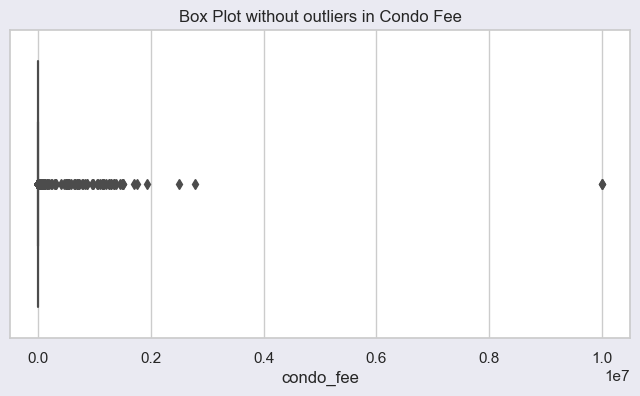

In [10]:
fig, ax = plt.subplots(figsize=(8,4),facecolor=facecolor)
sns.boxplot(salvador, x='condo_fee',showfliers=True)
plt.title('Box Plot without outliers in Condo Fee',**hfont)
plt.show()

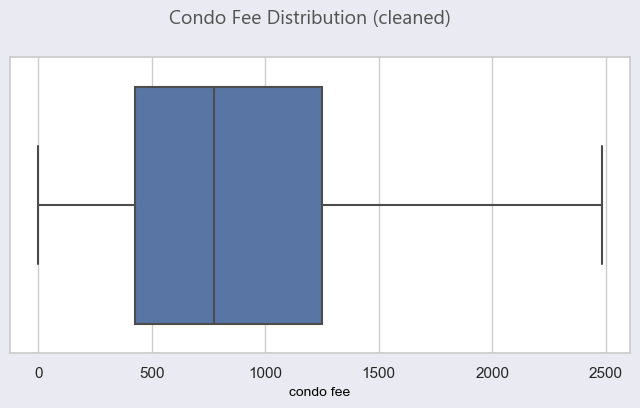

In [11]:
fig, ax = plt.subplots(figsize=(8,4),facecolor=facecolor)
sns.boxplot(salvador, x='condo_fee',showfliers=False)
ax.set_xlabel("condo fee", fontsize=10, color='black', **hfont)
ax.xaxis.label.set_color('black')
title = 'Condo Fee Distribution (cleaned)'
fig.suptitle(title, y=.97, fontsize=14, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)
plt.show()

### Cleaning condo fee

We will write a function in order to keep only the values where the condominium fee is within a more reasonable range between 150 and 10000 Brazilian Real (BRL) and replacing the excessive values. The function has been generated based on research from Loft.com.br and the maximum of 10,000 BRL is to accomadate for luxury properties to attempt to make it universal for all cities.

In [12]:
def condo_fee(condo_fee):
    if pd.isna(condo_fee) or (pd.notna(condo_fee) and (condo_fee < 150 or condo_fee > 10000)):
        return np.nan
    else:
        return float(condo_fee)

In [13]:
salvador['condo_fee']=pd.to_numeric(salvador['condo_fee'],errors='coerce')
salvador['condo_fee']=salvador['condo_fee'].apply(condo_fee)

In [14]:
salvador['condo_fee'].describe()

count    28964.000000
mean      1086.906159
std        743.854569
min        150.000000
25%        600.000000
50%        872.000000
75%       1370.000000
max       9000.000000
Name: condo_fee, dtype: float64

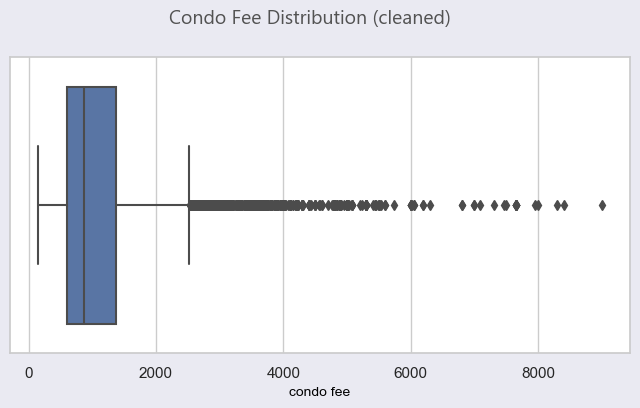

In [15]:
fig, ax = plt.subplots(figsize=(8,4),facecolor=facecolor)
sns.boxplot(salvador, x='condo_fee',showfliers=True)
ax.set_xlabel("condo fee", fontsize=10, color='black', **hfont)
ax.xaxis.label.set_color('black')
title = 'Condo Fee Distribution (cleaned)'
fig.suptitle(title, y=.97, fontsize=14, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)
plt.show()

### Condo Fee conclusion

In our condo fee column we have dropped the outliers below 150 and 10000 Brazilian Real (BRL) and now we will categorise the condo fee to determine whwether there is a difference between the price of a property and the condominium fee.

In [16]:
def condo_fee_range(condo_fee):
    if condo_fee < 250:
        return 'less than 250'
    elif condo_fee < 500:
        return '250 to 500'
    elif condo_fee < 750:
        return '500 to 750'
    elif condo_fee < 1000:
        return '750 to 1000'
    elif condo_fee < 1500:
        return '1000 to 1500'
    elif condo_fee < 2000:
        return '1500 to 2000'
    elif condo_fee < 2500:
        return '2000 to 2500'
    elif condo_fee < 3000:
        return '2500 to 3000'
    elif condo_fee < 5000:
        return '3000 to 5000'
    elif condo_fee > 5000:
        return 'greater than 5000'
    else: return 'No Condo Fee'

In [17]:
salvador['condo_fee_range']=salvador['condo_fee'].apply(condo_fee_range)

In [18]:
condo_fee_data=salvador[(salvador['condo_fee_range']!='No Condo Fee')&salvador['unit_type'].isin(['APARTMENT',
                                                                                                'FLAT','PENTHOUSE',
                                                                                               'KITNET'])].copy()
condo_fee_data.head()

,prop_id,address,sqm,price,neighborhood_list,zip_code,zone,num_bathrooms,num_bedrooms,num_parkings,price_rent,type_rent,condo_fee,amenities,date_created,date_updated,building_status,unit_type,listing_type,property_type,publication_type,usage_type,id,provider_id,date_scraped,street_num,street,date_first_created,neighborhood_list_original,unit_cat,ppsqm,geometry,neighborhood,condo_fee_range
82,d46ed915b06e1aca995c213ecb128ef4,LARGO DA CRUZ DA REDENCAO,283.0,480000.0,CANDEAL,40296310,NaN,3,4,3,<NA>,SALE,1800.0,"BARBECUE_GRILL,SAFETY_CIRCUIT,ELEVATOR,INTERCO...",2023-07-20 00:27:23.964000+00:00,2023-11-19 05:01:03.879000+00:00,ConstructionStatus_NONE,APARTMENT,USED,UNIT,STANDARD,RESIDENTIAL,2645295973,59293,2023-11-20 17:40:09.877773+00:00,nan,LARGO DA CRUZ DA REDENCAO,2023-07-20 00:27:23.964000+00:00,Candeal,APARTMENT,1696.113074,POINT (-38.47678 -12.99220),BROTAS,1500 to 2000
93,78ecacfa5f2ae1dab94ba670c467f378,RUA PROFESSOR GERSON PINTO,340.0,700000.0,COSTA AZUL,41760130,NaN,5,5,2,<NA>,SALE,1200.0,"KITCHEN,BUILTIN_WARDROBE",2023-03-22 21:34:27.616000+00:00,2023-11-14 21:16:08.010000+00:00,ConstructionStatus_NONE,PENTHOUSE,USED,UNIT,STANDARD,RESIDENTIAL,2620235629,12638,2023-11-20 17:40:10.481039+00:00,nan,RUA PROFESSOR GERSON PINTO,2023-03-22 21:34:27.616000+00:00,Costa Azul,PENTHOUSE,2058.823529,POINT (-38.44633 -12.99178),COSTA AZUL,1000 to 1500
117,9949a906be7485e165b69dbee89d6d50,RUA DOUTOR RENATO MENDONCA,255.0,650000.0,BROTAS,40285440,NaN,5,5,2,<NA>,SALE,266.0,"PLAYGROUND,BUILTIN_WARDROBE,GARAGE",2022-02-12 09:13:48.570000+00:00,2023-11-14 21:18:18.609000+00:00,ConstructionStatus_NONE,APARTMENT,USED,UNIT,STANDARD,RESIDENTIAL,2551305757,12638,2023-11-20 17:40:12.143866+00:00,nan,RUA DOUTOR RENATO MENDONCA,2022-02-12 09:13:48.570000+00:00,Brotas,APARTMENT,2549.019608,POINT (-38.48303 -12.98575),BROTAS,250 to 500
121,d10e78424f7adb2c564bcaec12cfc072,RUA CRISTIANO BUYS,240.0,640000.0,GRACA,41150120,NaN,3,4,2,<NA>,SALE,1900.0,"RECREATION_AREA,PARTY_HALL,KITCHEN,PLAYGROUND",2022-03-18 18:23:27.712000+00:00,2023-11-19 01:18:03.214000+00:00,ConstructionStatus_NONE,APARTMENT,USED,UNIT,STANDARD,RESIDENTIAL,2555170254,6647,2023-11-20 17:40:12.145866+00:00,nan,RUA CRISTIANO BUYS,2022-03-18 18:23:27.712000+00:00,Graça,APARTMENT,2666.666667,POINT (-38.47783 -12.96349),RETIRO,1500 to 2000
157,8142e6d4c4927221f645b30ecb30a48f,RUA MINAS GERAIS,200.0,410000.0,PITUBA,41830020,NaN,3,4,1,<NA>,SALE,1700.0,"KITCHEN_CABINETS,GARAGE,GATED_COMMUNITY,KITCHEN",2022-08-26 07:33:12.693000+00:00,2023-11-14 13:54:07.708000+00:00,ConstructionStatus_NONE,APARTMENT,USED,UNIT,STANDARD,RESIDENTIAL,2577703829,53236,2023-11-20 17:40:15.167158+00:00,nan,RUA MINAS GERAIS,2022-08-26 07:33:12.693000+00:00,Pituba,APARTMENT,2050.000000,POINT (-38.46409 -13.00902),PITUBA,1500 to 2000


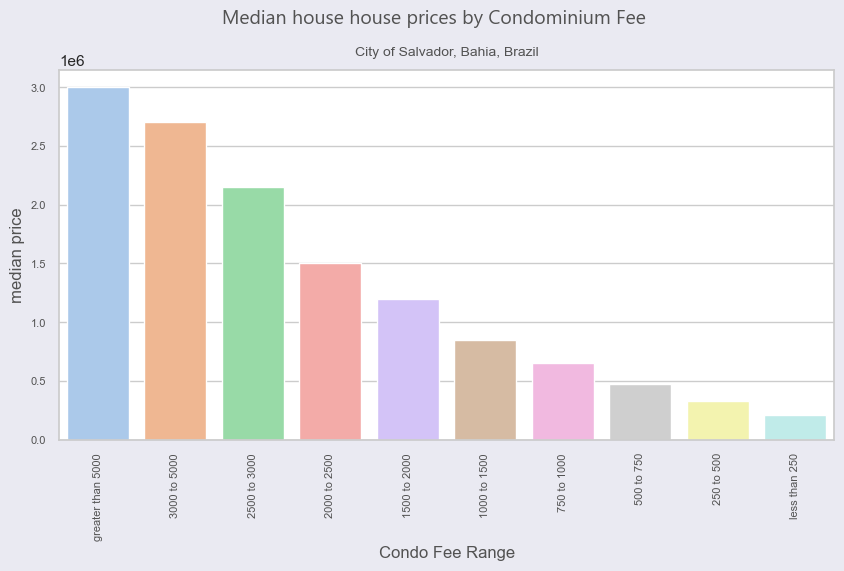

In [21]:
agg_condo_fee=condo_fee_data.groupby('condo_fee_range').agg({'price':['min','median','mean','max','count']}).reset_index()
agg_condo_fee.columns=['condo fee range','min','median price','mean','max','count']
agg_condo_fee=agg_condo_fee.sort_values(by='median price',ascending=False)

fig, ax = plt.subplots(figsize=(10, 5), facecolor=facecolor)

ax = sns.barplot(agg_condo_fee, x='condo fee range', y='median price',palette='pastel')

ax.set_ylabel('median price', fontsize=12, color=font_color, **hfont)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=12, color=font_color, **hfont)
    
ax.set_xlabel('Condo Fee Range', fontsize=12, color=font_color, **hfont)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=8, color=font_color, **hfont)
                 
title = 'Median house house prices by Condominium Fee'
fig.suptitle(title, y=.97, fontsize=14, color=font_color, **csfont)
subtitle = 'City of Salvador, Bahia, Brazil'
plt.title(subtitle, fontsize=10, pad=10, color=font_color, **hfont)
plt.subplots_adjust(top=0.85)
plt.xticks(rotation=90)
plt.show()

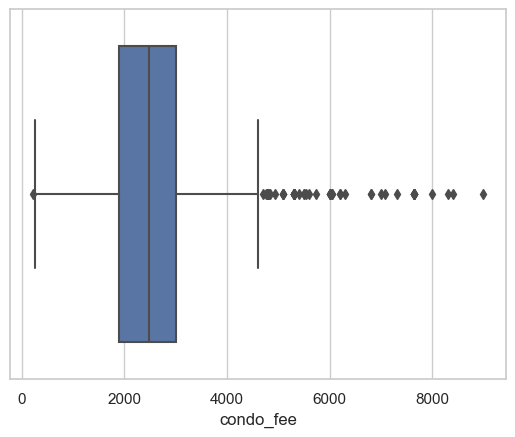

In [22]:
sns.boxplot(data=luxury_condos, x='condo_fee')
plt.show()

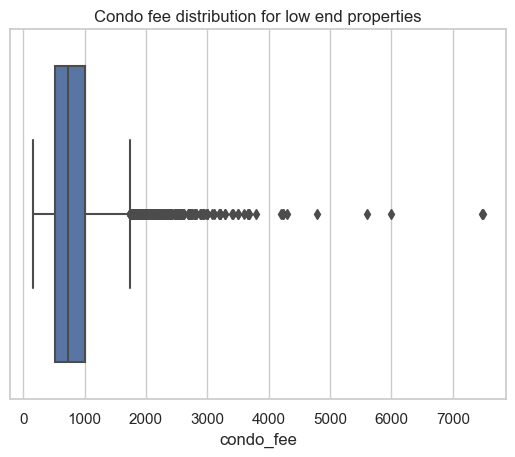

In [39]:
low_priced=condo_fee_data[condo_fee_data['price']<1000000]
low_priced.describe()
sns.boxplot(data=low_priced, x='condo_fee')
plt.title('Condo fee distribution for low end properties')
plt.show()

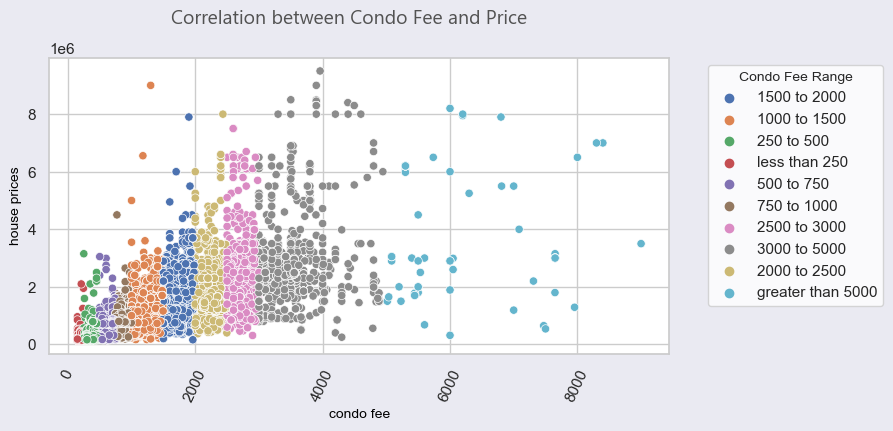

In [23]:
fig, ax = plt.subplots(figsize=(8,4),facecolor=facecolor)
sns.scatterplot(data=condo_fee_data, x='condo_fee', y='price', hue='condo_fee_range',
                palette="deep", marker='o')

ax.set_ylabel("house prices", fontsize=10, color='black', **hfont)
ax.yaxis.label.set_color('black')
ax.set_xlabel("condo fee", fontsize=10, color='black', **hfont)
ax.xaxis.label.set_color('black')
title = 'Correlation between Condo Fee and Price'
fig.suptitle(title, y=.97, fontsize=14, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)
legend = plt.legend(title='Condo Fee Range', bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_title().set_fontsize('10')
plt.xticks(rotation=65)
plt.show()

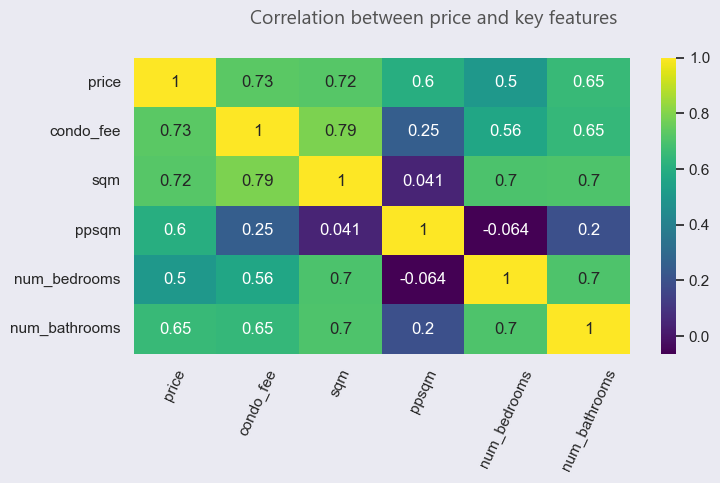

In [59]:
correlation_matrix=condo_fee_data[['price','condo_fee','sqm','ppsqm','num_bedrooms','num_bathrooms']].corr()
fig, ax = plt.subplots(figsize=(8,4),facecolor=facecolor)
sns.heatmap(data=correlation_matrix, annot=True, fmt='.2g', cmap='viridis')

title = 'Correlation between price and key features'
fig.suptitle(title, y=.97, fontsize=14, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)
plt.xticks(rotation=65)
plt.show()

## Neighborhood Analysis

We will now look at one of the most popular neighbourhoods in Salvador based on the total number of properties listing on the sales market. This is the economic centre of the city Pituba.

In [24]:
bairro_prices=condo_fee_data.groupby('neighborhood').agg({'price':'median',
                                                          'condo_fee':'median',
                                                          'prop_id':'count'}).reset_index()
bairro_prices.columns=['bairro','median price', 'median condo fee', 'count']
bairro_prices['bairro']=bairro_prices['bairro'].str.title()
bairro_prices_10=bairro_prices.sort_values(by='count',ascending=False).head(10)
bairro_prices_10

,bairro,median price,median condo fee,count
92,Pituba,659610.0,990.0,4855
85,Patamares,1200000.0,967.5,2346
27,Caminho Das Arvores,695000.0,1000.0,1646
11,Barra,660000.0,913.0,1471
53,Graca,780000.0,1335.0,1295
61,Jardim Armacao,550000.0,800.0,1122
83,Ondina,800000.0,1350.0,1072
57,Imbui,450000.0,580.0,1023
55,Horto Florestal,2199995.0,2131.0,986
20,Brotas,379840.0,666.5,914


In [25]:
bairro_lower=bairro_prices.sort_values(by='count',ascending=True)
bairro_lower[bairro_lower['count']>99].head(10)

,bairro,median price,median condo fee,count
17,Boca Do Rio,380000.0,560.0,116
30,Canabrava,550000.0,606.0,117
52,Garcia,444995.0,795.0,142
63,Jardim Das Margaridas,200000.0,318.0,157
66,Luiz Anselmo,320000.0,420.0,186
6,Amaralina,330000.0,560.0,186
39,Chame-Chame,790000.0,1490.0,195
21,Cabula,399475.0,544.0,196
59,Itapua,355000.0,466.0,233
0,Acupe,439995.0,620.0,244


In [26]:
pituba_data=condo_fee_data[condo_fee_data['neighborhood']=='PITUBA']

In [27]:
boca_do_rio_data=condo_fee_data[condo_fee_data['neighborhood']=='BOCA DO RIO']

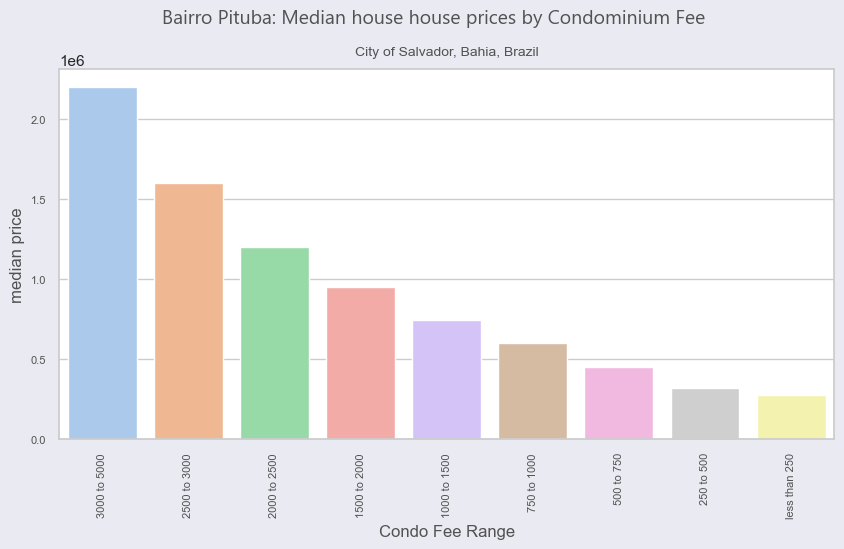

In [40]:
pituba_condo_fee=pituba_data.groupby('condo_fee_range').agg({'price':['min','median','mean','max','count']}).reset_index()
pituba_condo_fee.columns=['condo fee range','min','median price','mean','max','count']
pituba_condo_fee=pituba_condo_fee.sort_values(by='median price',ascending=False)

fig, ax = plt.subplots(figsize=(10, 5), facecolor=facecolor)

ax = sns.barplot(pituba_condo_fee, x='condo fee range', y='median price',palette='pastel')

ax.set_ylabel('median price', fontsize=12, color=font_color, **hfont)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=12, color=font_color, **hfont)
    
ax.set_xlabel('Condo Fee Range', fontsize=12, color=font_color, **hfont)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=8, color=font_color, **hfont)
                 
title = 'Bairro Pituba: Median house house prices by Condominium Fee'
fig.suptitle(title, y=.97, fontsize=14, color=font_color, **csfont)
subtitle = 'City of Salvador, Bahia, Brazil'
plt.title(subtitle, fontsize=10, pad=10, color=font_color, **hfont)
plt.subplots_adjust(top=0.85)
plt.xticks(rotation=90)
plt.show()

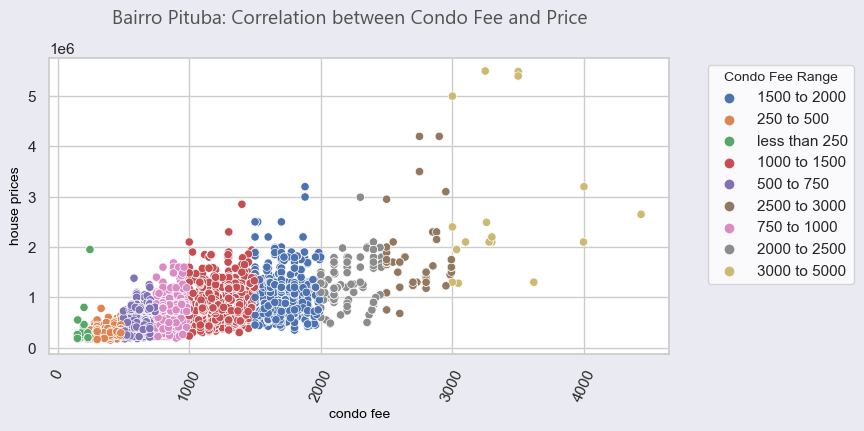

In [41]:
fig, ax = plt.subplots(figsize=(8,4),facecolor=facecolor)
sns.scatterplot(data=pituba_data, x='condo_fee', y='price', hue='condo_fee_range',
                palette="deep", marker='o')

ax.set_ylabel("house prices", fontsize=10, color='black', **hfont)
ax.yaxis.label.set_color('black')
ax.set_xlabel("condo fee", fontsize=10, color='black', **hfont)
ax.xaxis.label.set_color('black')

title = 'Bairro Pituba: Correlation between Condo Fee and Price'
fig.suptitle(title, y=.97, fontsize=14, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)
legend = plt.legend(title='Condo Fee Range', bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_title().set_fontsize('10')
plt.xticks(rotation=65)
plt.show()

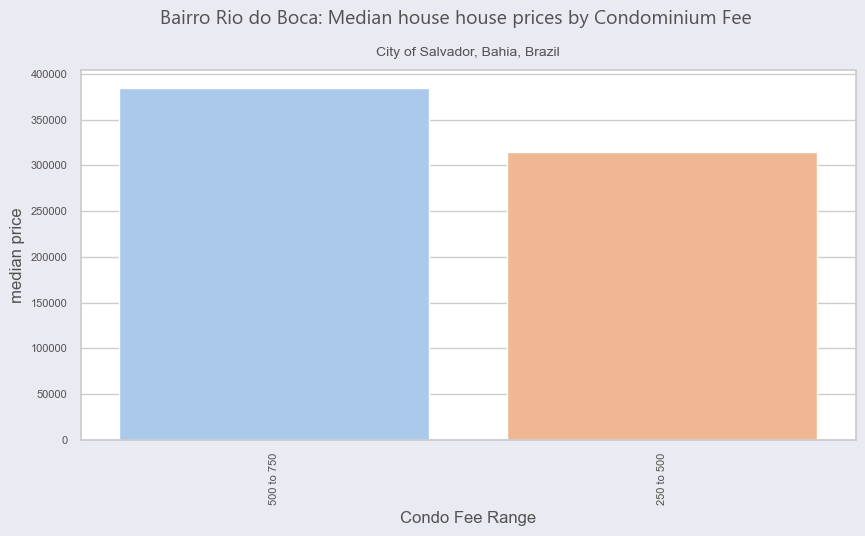

In [44]:
boca_do_rio_condo_fee=boca_do_rio_data.groupby('condo_fee_range').agg({'price':['min','median','mean','max','count']}).reset_index()
boca_do_rio_condo_fee.columns=['condo fee range','min','median price','mean','max','count']
boca_do_rio_condo_fee=boca_do_rio_condo_fee[boca_do_rio_condo_fee['count']>10]
boca_do_rio_condo_fee=boca_do_rio_condo_fee.sort_values(by='median price',ascending=False)

fig, ax = plt.subplots(figsize=(10, 5), facecolor=facecolor)

ax = sns.barplot(boca_do_rio_condo_fee, x='condo fee range', y='median price',palette='pastel')

ax.set_ylabel('median price', fontsize=12, color=font_color, **hfont)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=12, color=font_color, **hfont)
    
ax.set_xlabel('Condo Fee Range', fontsize=12, color=font_color, **hfont)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=8, color=font_color, **hfont)
                 
title = 'Bairro Rio do Boca: Median house house prices by Condominium Fee'
fig.suptitle(title, y=.97, fontsize=14, color=font_color, **csfont)
subtitle = 'City of Salvador, Bahia, Brazil'
plt.title(subtitle, fontsize=10, pad=10, color=font_color, **hfont)
plt.subplots_adjust(top=0.85)
plt.xticks(rotation=90)
plt.show()

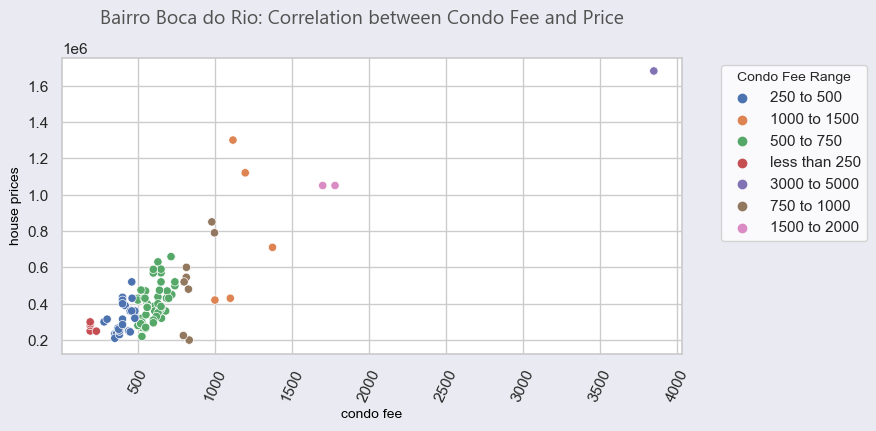

In [42]:
fig, ax = plt.subplots(figsize=(8,4),facecolor=facecolor)
sns.scatterplot(data=boca_do_rio_data, x='condo_fee', y='price', hue='condo_fee_range',
                palette="deep", marker='o')

ax.set_ylabel("house prices", fontsize=10, color='black', **hfont)
ax.yaxis.label.set_color('black')
ax.set_xlabel("condo fee", fontsize=10, color='black', **hfont)
ax.xaxis.label.set_color('black')

title = 'Bairro Boca do Rio: Correlation between Condo Fee and Price'
fig.suptitle(title, y=.97, fontsize=14, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)
legend = plt.legend(title='Condo Fee Range', bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_title().set_fontsize('10')
plt.xticks(rotation=65)
plt.show()

### Price conclusions

As anticipated, the correlation between condominium fees and median property prices in Salvador is evident. Notably, a discernible trend emerges wherein higher condo fees correspond to elevated median house prices. For instance, when the condominium fee surpasses 3,000 Brazilian Real (BRL), the median house price in Salvador reaches 2.5 million BRL. It is noteworthy that properties priced below 1 million BRL generally exhibit condominium fees below 1,500 BRL.

A more nuanced observation surfaces when scrutinizing properties valued over 2 million BRL. The majority of such properties still fall below the 3,000 BRL threshold. However, outliers persist, with a select few exceeding 5,000 BRL. This suggests that a condominium fee limit of 10,000 BRL may be more fitting to capture values associated with luxury properties. Previously, a cap of 5,000 BRL was implemented, resulting in the exclusion of these high-end properties from the analysis. Nevertheless, the new cap does help to improve the accuracy of the condominium fee as we have value stretching as far as 9,999,999 BRL.

Conversely, properties valued below 1 million BRL present a different scenario. Here, a substantial number of outliers above the interquartile range (IQR) are observed. Several factors could contribute to this variance, including fluctuations in advertised prices while the condominium fee remains constant. Furthermore, the estimation or reduction of the condominium fee by the advertiser, coupled with the property type, could collectively impact the observed disparities.

#### Bairros

When we look at the most popular neighbourhood in Salvador, Pituba; the economic centre of the city, the distribution is clear and our clusters show much fewer outliers as the condominium fee rises in line with the property price.

In contrast to our most popular neighbourhood the neighbourhood of Boca do Rio has very few properties with a condo fee over 1000 BRL, moreover, the house prices are significantly lower with a median price of 380000 BRL, compare to Pituba which had a median price of 743000 BRL.